In [1]:
import os
import sys
import json
import time
import pickle
import gspread
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy import integrate, signal, stats, fftpack

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    get_stim_events,
    get_evoked_traces,
    get_evoked_firing_rates,
    find_nearest_ind
)
from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import remove_lfp_offset
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib notebook

Load CCF for identifying cortical areas

In [5]:
mcc = MouseConnectivityCache(resolution=10)
str_tree = mcc.get_structure_tree()

Load Zap_Zip-log_exp to get metadata for experiments

In [6]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

Define areas of interest to plot population activity

In [7]:
areas_of_interest = {
    'MO': [
        'MOp1', 'MOp2/3', 'MOp5', 'MOp6a', 'MOp6b',
        'MOs1', 'MOs2/3', 'MOs5', 'MOs6a', 'MOs6b'
    ],
    'ACA': [
        'ACAd1', 'ACAd2/3', 'ACAd5', 'ACAd6a', 'ACAd6b',
        'ACAv1', 'ACAv2/3', 'ACAv5', 'ACAv6a', 'ACAv6b'
    ],
    'SS': [
        'SSp-bfd1', 'SSp-bfd2/3', 'SSp-bfd4', 'SSp-bfd5', 'SSp-bfd6a', 'SSp-bfd6b',
        'SSp-ll1', 'SSp-ll2/3', 'SSp-ll4', 'SSp-ll5', 'SSp-ll6a', 'SSp-ll6b',
        'SSp-tr1', 'SSp-tr2/3', 'SSp-tr4', 'SSp-tr5', 'SSp-tr6a', 'SSp-tr6b'
    ],
    'VIS': [
        'VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b',
        'VISam1', 'VISam2/3', 'VISam4', 'VISam5', 'VISam6a', 'VISam6b',
        'VISpm1', 'VISpm2/3', 'VISpm4', 'VISpm5', 'VISpm6a', 'VISpm6b',
        'VISrl1', 'VISrl2/3', 'VISrl4', 'VISrl5', 'VISrl6a', 'VISrl6b',
    ],
    'MO-TH': [
        'AV', 'CL', 'MD', 'PO', 'RT', 'VAL', 'VPL', 'VPM', 'VM'
    ],
}

In [8]:
area_colors = {
    'MO': (31/255, 157/255, 90/255), # [31, 157, 90] 'blue'
    'ACA': (64/255, 166/255, 102/255), # [64, 166, 102] 'deepskyblue'
    'SS': (24/255, 128/255, 100/255), # [24, 128, 100] 'blueviolet'
    'VIS': (8/255, 133/255, 140/255), # [8, 133, 140] 'green'
    'MO-TH': (255/255, 112/255, 128/255), # [255, 112, 128] 'steelblue'
#     'VIS-TH': 'olivedrab'
}

In [9]:
# state_colors = {
#     'awake': (120/255, 156/255, 74/255),
#     'anesthetized': (130/255, 122/255, 163/255),
#     'recovery': (93/255, 167/255, 229/255)
# }
state_colors = {
    'resting': 'royalblue',
    'running': 'seagreen',
    'anesthetized': 'indianred',
}

#### Functions

In [10]:
def get_stim_event_inds(stim_table, stim_type, stim_param, sweep, trials='stationary'):
    if trials == 'resting':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == True)
        ].index.values
    elif trials == 'running':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == False)
        ].index.values
    else:
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True)
        ].index.values

## Load subjects from file

In [11]:
with open(r'C:\Users\lesliec\OneDrive - Allen Institute\data\all_iso_subjects_wPROBES.json') as subjects_file:
    multi_sub_dict = json.load(subjects_file)

In [12]:
for group, group_subs in multi_sub_dict.items():
    print(group)
    print('')
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        mdata['exp'] = EEGexp(mdata['data_loc'], preprocess=False, make_stim_csv=False)
    print('')

MOs_superficial

 575102
Experiment type: electrical and sensory stimulation
 571619
Experiment type: electrical stimulation

MOs_deep

 546655
Experiment type: electrical and sensory stimulation
 551399
Experiment type: electrical stimulation
 551397
Experiment type: electrical and sensory stimulation
 569062
Experiment type: electrical and sensory stimulation
 569068
Experiment type: electrical and sensory stimulation
 569069
Experiment type: electrical and sensory stimulation
 569064
Experiment type: electrical and sensory stimulation
 569073
Experiment type: electrical and sensory stimulation
 571619
Experiment type: electrical stimulation

SSp_superficial

 571620
Experiment type: electrical and sensory stimulation
 586466
Experiment type: electrical and sensory stimulation
 590479
Experiment type: electrical stimulation
 590480
Experiment type: electrical and sensory stimulation
 599017
Experiment type: electrical and sensory stimulation

SSp_deep

 569073
Experiment type: electr

In [13]:
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\manuscript_figs'

## All subjects

In [14]:
## Parameters ##
ctx_regions = ['MO', 'ACA', 'SS', 'VIS']
time_bin = 0.01 # size of time bins (s)

current_levels = ['low', 'medium', 'high']
test_states = ['awake', 'anesthetized']

sigalpha = 0.01

example_mice = {'MOs_deep': '571619',}

In [15]:
for group, group_subs in multi_sub_dict.items():
    print(group)
    print('')
    stim_area = group[:2]
    stim_depth = group.split('_')[-1]
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        evoked_data_folder = os.path.join(mdata['exp'].data_folder, 'evoked_data')
        
        ## Load unit info ##
        fn_units_info = os.path.join(evoked_data_folder, 'all_units_info.csv')
        if os.path.exists(fn_units_info):
            unit_info = pd.read_csv(fn_units_info)
            with open(os.path.join(evoked_data_folder, 'units_event_spikes.pkl'), 'rb') as unit_file:
                all_unit_event_spikes = pickle.load(unit_file)
        else:
            print('  {} not found. Not analyzing this subject.'.format(fn_units_stats))
            continue

        ## Grab exp metadata from Zap_Zip-log_exp ##
        exp_meta = zzmetadata[(
            (zzmetadata['mouse_name'].str.contains(mdata['exp'].mouse)) &
            (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(mdata['exp'].experiment_folder))))
        )].squeeze()
        currentstr = exp_meta['Current (uA)'].replace(' ','')
        currents_list = []
        for char in currentstr.split('/'):
            if char.isdecimal():
                currents_list.append(char)
        try:
            bad_chs = mdata['bad_chs']
        except KeyError:
            badchstr = exp_meta['EEG bad_channels'].replace(' ','')
            bad_chs = []
            for char in badchstr.split(','):
                if char.isdecimal():
                    bad_chs.append(int(char))

        ## Load stim log (includes running speed now) ##
        stim_log = pd.read_csv(mdata['exp'].stimulus_log_file)
        stim_log = stim_log.astype({'parameter': str})
        event_window = all_unit_event_spikes['event_window']
        bins = np.arange(event_window[0], event_window[1] + time_bin, time_bin)
        timex = bins[:-1] + time_bin/2
        
        ## Load EEG traces ##
        all_EEG_traces = np.load(os.path.join(evoked_data_folder, 'event_EEGtraces.npy'))
        EEG_event_timestamps = np.load(os.path.join(evoked_data_folder, 'event_EEGtraces_times.npy'))
        eeg_chs = np.arange(0, all_EEG_traces.shape[1])
        GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])
        mdata['good_chs'] = GOOD_CHS

        ## Get event inds ##
        all_event_inds = {}
        for leveli, parami in zip(current_levels, currents_list):
            all_event_inds[leveli] = {}
            for statei in ['awake', 'anesthetized']:
                sweeps = mdata['states'][statei]
                if not sweeps:
                    continue
                state_events = []
                for sweepi in sweeps:
                    events = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials='all')
                    if len(events) == 0:
                        continue
                    state_events.append(events)
                all_event_inds[leveli][statei] = np.concatenate(state_events)
                if statei == 'awake':
                    substates = ['resting', 'running']
                    for substatei in substates:
                        state_events = []
                        for sweepi in sweeps:
                            events = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials=substatei)
                            if len(events) == 0:
                                continue
                            state_events.append(events)
                        all_event_inds[leveli][substatei] = np.concatenate(state_events)

        ## Loop through regions to get units: RS only for CTX, all units for MO-TH ##
        reg_unit_info = {}
        for region in [stim_area, 'MO-TH']:
            if region in ctx_regions:
                regdf = unit_info[(unit_info['cell_type'] == 'RS') & (unit_info['parent'] == region)]
            else:
                regdf = unit_info[unit_info['parent'] == region]
            if len(regdf) > 8:
                reg_unit_info[region] = regdf.sort_values(by='depth').reset_index(drop=True)
        if len(reg_unit_info) == 0:
            print('  Not enough units in cortex or thalamus; not analyzing this subject.')
            continue
        
        start = time.time()
        EEG_traces = {}
        pop_firing_rate = {}
        unit_event_bursts = {}
        for leveli, states_event_times in all_event_inds.items():
            EEG_traces[leveli] = {}
            pop_firing_rate[leveli] = {}
            unit_event_bursts[leveli] = {}
            for statei, event_inds in states_event_times.items():
                pop_firing_rate[leveli][statei] = {}
                unit_event_bursts[leveli][statei] = {}
                
                ## Get evoked EEG traces ##
                event_traces = all_EEG_traces[:, :, event_inds]
                event_traces = event_traces - np.mean(event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
                EEG_traces[leveli][statei] = [EEG_event_timestamps, event_traces]
                
                for regi, regdf in reg_unit_info.items():
                    ## Get population event spike times ##
                    popFRs = np.zeros((len(timex), len(event_inds)), dtype=float) * np.nan
                    for ei, eventi in enumerate(event_inds):
                        event_spikes = []
                        for ii, unitrow in regdf.iterrows():
                            event_spikes.append(all_unit_event_spikes['event_spikes'][unitrow.unit_id][eventi])
                        spcounts, edges = np.histogram(np.sort(np.concatenate(event_spikes)), bins)
                        popFRs[:, ei] = spcounts / time_bin
                    pop_firing_rate[leveli][statei][regi] = [timex, popFRs]

                    ## Get unit event burst times ##
                    for ii, unitrow in regdf.iterrows():
                        unit_event_bursts[leveli][statei][unitrow.unit_id] = [
                            all_unit_event_spikes['event_bursts'][unitrow.unit_id]['times'][ei] for ei in event_inds
                        ]
                    
        mdata['EEG'] = EEG_traces
        mdata['popFR'] = pop_firing_rate
        mdata['unit_info'] = reg_unit_info
        mdata['bursts'] = unit_event_bursts
        
        del EEG_traces, pop_firing_rate, reg_unit_info, unit_event_bursts
        del unit_info, all_unit_event_spikes, all_EEG_traces, EEG_event_timestamps
        end = time.time()
        print('  Time to get event data: {:.2f} s'.format(end-start))
    print('')

MOs_superficial

 575102
  Time to get event data: 15.26 s
 571619
  Time to get event data: 24.01 s

MOs_deep

 546655
  Time to get event data: 16.21 s
 551399
  Time to get event data: 25.51 s
 551397
  Time to get event data: 29.35 s
 569062
  Time to get event data: 34.23 s
 569068
  Time to get event data: 22.43 s
 569069
  Time to get event data: 21.67 s
 569064
  Time to get event data: 16.69 s
 569073
  Time to get event data: 23.47 s
 571619
  Time to get event data: 25.09 s

SSp_superficial

 571620
  Time to get event data: 22.09 s
 586466
  Time to get event data: 17.93 s
 590479
  Time to get event data: 20.67 s
 590480
  Time to get event data: 26.26 s
 599017
  Not enough units in cortex or thalamus; not analyzing this subject.

SSp_deep

 569073
  Time to get event data: 21.32 s
 569072
  Time to get event data: 29.88 s
 571620
  Time to get event data: 23.56 s
 586466
  Time to get event data: 15.65 s
 590479
  Time to get event data: 22.47 s
 590480
  Time to get eve

### Test correlation between EEG and spiking activity metrics

In [16]:
## Tests Pearson correlation only now ##
test_window = [0.15, 0.3]

pstim = 'medium'
pstate = 'resting'
regi = 'MO-TH'

all_subs_stats = []
for group, group_subs in multi_sub_dict.items():
    print(group)
    stim_area = group[:2]
    stim_depth = group.split('_')[-1]
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        if 'popFR' not in mdata.keys():
            print('  No region data.')
            continue
        if regi not in mdata['popFR'][pstim][pstate].keys():
            print('  No {} data.'.format(regi))
            continue
        
        # EEG #
        eegtime = mdata['EEG'][pstim][pstate][0]
        eegtraces = mdata['EEG'][pstim][pstate][1]
        eeginds = np.nonzero((eegtime >= test_window[0]) & (eegtime <= test_window[1]))[0]
        bleeginds = np.nonzero((eegtime >= -test_window[1]) & (eegtime <= -test_window[0]))[0]
        
        # popFR #
        frtime = mdata['popFR'][pstim][pstate][regi][0]
        popFR = mdata['popFR'][pstim][pstate][regi][1]
        frinds = np.nonzero((frtime >= test_window[0]) & (frtime <= test_window[1]))[0]
        blfrinds = np.nonzero((frtime >= -test_window[1]) & (frtime <= -test_window[0]))[0]
        
        # units #
        reg_unit_info = mdata['unit_info'][regi]
        event_bursts = mdata['bursts'][pstim][pstate]
        
        EEGauc = np.zeros((eegtraces.shape[1], eegtraces.shape[2]), dtype=float)
        blEEGauc = np.zeros((eegtraces.shape[1], eegtraces.shape[2]), dtype=float)
        FRauc = np.zeros(eegtraces.shape[2], dtype=float)
        blFRauc = np.zeros(eegtraces.shape[2], dtype=float)
        pop_fraction = np.zeros(eegtraces.shape[2], dtype=float)
        for jj in range(eegtraces.shape[2]):
            ## Get EEG metrics ##
            blEEGauc[:, jj] = integrate.simps(np.abs(eegtraces[bleeginds, :, jj]), eegtime[bleeginds], axis=0, even='last')
            EEGauc[:, jj] = integrate.simps(np.abs(eegtraces[eeginds, :, jj]), eegtime[eeginds], axis=0, even='last')
            
            ## Get popFR magnitude ##
            blFRauc[jj] = integrate.simps(popFR[blfrinds, jj], frtime[blfrinds], axis=0, even='last')
            FRauc[jj] = integrate.simps(popFR[frinds, jj], frtime[frinds], axis=0, even='last')
            
            ## Get pop fraction ##
            uc = 0
            for ui, unitrow in reg_unit_info.iterrows():
                uid = unitrow.unit_id
                uburstsi = np.array(event_bursts[uid][jj])
                counts = np.nonzero((uburstsi >= test_window[0]) & (uburstsi <= test_window[1]))[0]
                if len(counts) > 0:
                    uc += 1
            pop_fraction[jj] = uc / len(reg_unit_info)
            
        EEGmag = (EEGauc - np.mean(blEEGauc, axis=0)) / np.std(blEEGauc, axis=0)
        FRmag = (FRauc - np.mean(blFRauc)) / np.std(blFRauc)
        
        popfr_rs, popfr_ps = np.zeros((eegtraces.shape[1]), dtype=float)*np.nan, np.ones((eegtraces.shape[1]), dtype=float)
        burst_rs, burst_ps = np.zeros((eegtraces.shape[1]), dtype=float)*np.nan, np.ones((eegtraces.shape[1]), dtype=float)
        for chi in mdata['good_chs']:
            popfr_rs[chi], popfr_ps[chi] = stats.pearsonr(FRmag, EEGmag[chi,:])
            burst_rs[chi], burst_ps[chi] = stats.pearsonr(pop_fraction, EEGmag[chi,:])
        
        all_subs_stats.append([
            group, mouse_num, stim_area, stim_depth, len(mdata['good_chs']), len(reg_unit_info),
            popfr_rs, popfr_ps, burst_rs, burst_ps
        ])
    print('')
## Create stats dataframe ##
all_subs_stats_df = pd.DataFrame(all_subs_stats, columns=[
    'group', 'mouse', 'stim_area', 'stim_depth', 'num_chs', 'num_units', 'popfr_R', 'popfr_P', 'burst_R', 'burst_P'
])

MOs_superficial
 575102
  No MO-TH data.
 571619

MOs_deep
 546655
 551399
 551397
 569062
 569068
 569069
 569064
  No MO-TH data.
 569073
 571619

SSp_superficial
 571620
 586466
  No MO-TH data.
 590479
  No MO-TH data.
 590480
 599017
  No region data.

SSp_deep
 569073
 569072
 571620
 586466
  No MO-TH data.
 590479
  No MO-TH data.
 590480
 599017
  No region data.



In [17]:
all_subs_stats_df.head()

,group,mouse,stim_area,stim_depth,num_chs,num_units,popfr_R,popfr_P,burst_R,burst_P
0,MOs_superficial,571619,MO,superficial,24,62,"[-0.0341724063150997, -0.032076071307004156, n...","[0.7505476402853168, 0.7653947970712458, 1.0, ...","[0.22692891745469296, 0.2382932887280653, nan,...","[0.032471074663461066, 0.02452686216267292, 1...."
1,MOs_deep,546655,MO,deep,22,30,"[-0.3593912157668147, -0.3922417031645928, -0....","[0.02275013701540034, 0.0123036764248627, 0.03...","[0.09499163583189836, 0.032168626942136194, 0....","[0.559859561766405, 0.8437871092166725, 0.9533..."
2,MOs_deep,551399,MO,deep,22,82,"[nan, nan, -0.30034980679733086, nan, nan, -0....","[1.0, 1.0, 0.0015871354399782252, 1.0, 1.0, 0....","[nan, nan, 0.48074527702655856, nan, nan, 0.46...","[1.0, 1.0, 1.394690725083745e-07, 1.0, 1.0, 4...."
3,MOs_deep,551397,MO,deep,27,120,"[-0.13188969433038245, 0.09096944086621393, 0....","[0.20021977521723433, 0.3780642407738461, 0.45...","[0.23504392676580635, 0.5468404660102137, 0.54...","[0.02115659741791064, 8.204782837186282e-09, 1..."
4,MOs_deep,569062,MO,deep,28,155,"[0.4108774208064491, 0.410741231654287, 0.3494...","[1.7904647247491602e-05, 1.8030970323837218e-0...","[0.5592222454362626, 0.5695064260253649, 0.531...","[1.0017184827061933e-09, 4.2012560968979053e-1..."


## Make figure 6

<IPython.core.display.Javascript object>


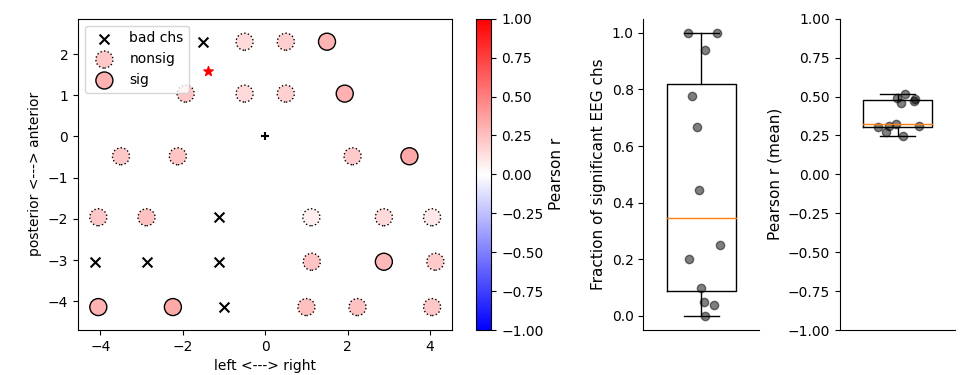

In [26]:
stim_depth = 'deep'
plot_val = 'burst' # choose burst or popfr

plotdf = all_subs_stats_df[all_subs_stats_df['stim_depth'] == stim_depth]
# plotdf = all_subs_stats_df[(all_subs_stats_df['stim_depth'] == stim_depth) & (all_subs_stats_df['stim_area'] == 'MO')]
rvals = np.stack(plotdf[plot_val + '_R'].values)
pvals = np.stack(plotdf[plot_val + '_P'].values)
num_good_chs = plotdf['num_chs'].values

fig = plt.figure(figsize=(9.75, 3.75))
gs = fig.add_gridspec(ncols=2, nrows=1, left=0.08, right=0.98, top=0.95, bottom=0.12, width_ratios=[3,2], wspace=0.25)
axEEG = fig.add_subplot(gs[0])
gsmet = gs[1].subgridspec(ncols=2, nrows=1, wspace=0.7)
axCHS = fig.add_subplot(gsmet[0])
axRS = fig.add_subplot(gsmet[1])

## Plot example EEG with r values ##
exgroup = list(example_mice.keys())[0]
exmouse = example_mice[exgroup]
goodchmask = np.array([True if x in multi_sub_dict[exgroup][exmouse]['good_chs'] else False for x in range(30)])
badchmask = ~goodchmask
exRs = plotdf[plot_val + '_R'][(plotdf['group'] == exgroup) & (plotdf['mouse'] == exmouse)].values[0]
exPs = plotdf[plot_val + '_P'][(plotdf['group'] == exgroup) & (plotdf['mouse'] == exmouse)].values[0]
sigmask = (exPs < sigalpha) * goodchmask
nonsigmask = (exPs >= sigalpha) * goodchmask
# plot bad chs #
axEEG.scatter(
    EEGexp.EEG_channel_coordinates['ML'][badchmask], EEGexp.EEG_channel_coordinates['AP'][badchmask],
    c='k', s=50, marker='x', label='bad chs'
)
# plot good chs, non significant #
axEEG.scatter(
    EEGexp.EEG_channel_coordinates['ML'][nonsigmask], EEGexp.EEG_channel_coordinates['AP'][nonsigmask],
    c=exRs[nonsigmask], s=150, cmap='bwr', vmin=-1, vmax=1, edgecolor='k', linestyle='dotted', label='nonsig'
)
# plot good chs, significant #
rcb = axEEG.scatter(
    EEGexp.EEG_channel_coordinates['ML'][sigmask], EEGexp.EEG_channel_coordinates['AP'][sigmask],
    c=exRs[sigmask], s=150, cmap='bwr', vmin=-1, vmax=1, edgecolor='k', label='sig'
)
axEEG.set_xlabel('left <---> right')
axEEG.set_ylabel('posterior <---> anterior')
axEEG.scatter(0, 0, marker='+', color='k')
axEEG.scatter(-1.4, 1.6, marker='*', color='r', s=50)
axEEG.axis('equal')
axEEG.legend(loc='upper left', prop={'size': 10})
# axEEG.set_title('Pearson corr')
cb = fig.colorbar(rcb, ax=axEEG, aspect=20)
cb.set_label('Pearson r', fontsize=11)

## Fraction of significant chs ##
num_sig_chs = np.sum(pvals < sigalpha, axis=1)
fr_sig_chs = num_sig_chs / num_good_chs
axCHS.boxplot(fr_sig_chs, positions=[1], widths=[0.3], showfliers=False)
x1s = np.random.normal(1, 0.04, len(fr_sig_chs))
axCHS.scatter(x1s, fr_sig_chs, color='k', alpha=0.5)
axCHS.set_ylabel('Fraction of significant EEG chs', fontsize=11)
axCHS.spines['right'].set_visible(False)
axCHS.spines['top'].set_visible(False)
axCHS.set_xticks([])
axCHS.set_xlim([0.75, 1.25])

## Average R of significant chs ##
meanR = []
for subr, subp in zip(rvals, pvals):
    if np.sum(subp < sigalpha) > 0:
        meanR.append(np.mean(subr[subp < sigalpha]))
meanR = np.array(meanR)
axRS.boxplot(meanR, positions=[1], widths=[0.3], showfliers=False)
x2s = np.random.normal(1, 0.04, len(meanR))
axRS.scatter(x2s, meanR, color='k', alpha=0.5)
axRS.set_ylabel('Pearson r (mean)', fontsize=11)
axRS.spines['right'].set_visible(False)
axRS.spines['top'].set_visible(False)
axRS.set_xticks([])
axRS.set_ylim([-1, 1])
axRS.set_xlim([0.75, 1.25])

## Save ##
figname = 'Fig5_v5_{}.png'.format(date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

In [28]:
plotdf['stim_area'].values == 'MO'

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False])

## Make combined plot for FR and bursting cells

<IPython.core.display.Javascript object>


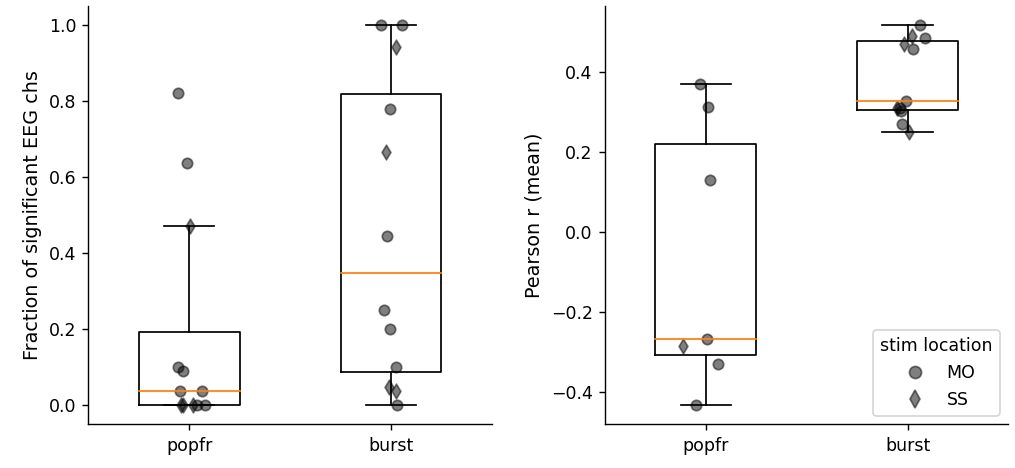

popfr
Mean fraction = 0.18 chs
Mean R value = -0.07
burst
Mean fraction = 0.46 chs
Mean R value = 0.38


In [20]:
stim_depth = 'deep'
plot_vals = ['popfr', 'burst'] # choose burst or popfr
stimloc_markers = {'MO': 'o', 'SS': 'd'}

plotdf = all_subs_stats_df[all_subs_stats_df['stim_depth'] == stim_depth]
num_good_chs = plotdf['num_chs'].values

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6.5, 3), sharex=True, constrained_layout=True)

for ii, metrici in enumerate(plot_vals):
    print(metrici)
    rvals = np.stack(plotdf[metrici + '_R'].values)
    pvals = np.stack(plotdf[metrici + '_P'].values)
    
    ## Fraction of significant chs ##
    num_sig_chs = np.sum(pvals < sigalpha, axis=1)
    fr_sig_chs = num_sig_chs / num_good_chs
    print('Mean fraction = {:.2f} chs'.format(np.mean(fr_sig_chs)))
    axs[0].boxplot(fr_sig_chs, positions=[ii], widths=[0.5], showfliers=False)
    x1s = np.random.normal(ii, 0.05, len(fr_sig_chs))
#     axs[0].scatter(x1s, fr_sig_chs, color='k', alpha=0.5)
    
    ## Average R of significant chs ##
    meanR = []
    stimloc = []
    for subr, subp, stimloci in zip(rvals, pvals, plotdf['stim_area'].values):
        if np.sum(subp < sigalpha) > 0:
            meanR.append(np.mean(subr[subp < sigalpha]))
            stimloc.append(stimloci)
    meanR = np.array(meanR)
    print('Mean R value = {:.2f}'.format(np.mean(meanR)))
    axs[1].boxplot(meanR, positions=[ii], widths=[0.5], showfliers=False)
    x2s = np.random.normal(ii, 0.05, len(meanR))
#     axs[1].scatter(x2s, meanR, color='k', alpha=0.5)
    
    for loci, mari in stimloc_markers.items():
        locs1 = plotdf['stim_area'].values == loci
        axs[0].scatter(x1s[locs1], fr_sig_chs[locs1], color='k', marker=mari, alpha=0.5)
        locs2 = [True if x == loci else False for x in stimloc]
        axs[1].scatter(x2s[locs2], meanR[locs2], color='k', marker=mari, alpha=0.5)
    
axs[0].set_ylabel('Fraction of significant EEG chs', fontsize=11)
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].set_xticks([0, 1])
axs[0].set_xticklabels(plot_vals)

axs[1].set_ylabel('Pearson r (mean)', fontsize=11)
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)

reghandles = []
for loci, mari in stimloc_markers.items():
    reghandles.append(
        Line2D([],[], color='k', linestyle='none', marker=mari, markersize=7, alpha=0.5, label=loci))
axs[1].legend(handles=reghandles, title='stim location')#, prop={'size': 9})


## Save ##
figname = 'ERPcorr_wTHburst_popfr_{}.png'.format(date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)